### Normalized images

In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from utils import  SaveFeatures, accuracy, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline

In [2]:
class ImageDataset(Dataset):
    def __init__(self, hs_dir, RGB_dir, labels_df, im_size):
        self.RGB_dir = RGB_dir
        self.hs_dir = hs_dir
        self.labels_df = labels_df
        self.im_size = im_size

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        RGB_img_path = os.path.join(self.RGB_dir, f"{img_name}.tif")
        hs_img_path = os.path.join(self.hs_dir, f"{img_name}_hs.tif")

        with rasterio.open(RGB_img_path) as RGB_src:
            # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(hs_img_path) as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img)
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=self.im_size*2, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img)
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

        means = combined_tensor.mean(dim=(1, 2), keepdim=True)
        stds = combined_tensor.std(dim=(1, 2), keepdim=True)

        # Normalize each map
        normalized_tensor = (combined_tensor - means) / stds

        label = self.labels_df.iloc[idx, 0]
        label = 1 if label > 0 else 0

        return normalized_tensor, label

In [3]:

###################
# Hyperparameters #

n_samples = 10000
n_samples_train = int(round(n_samples*0.8))
n_samples_val = int(round(n_samples*0.2))
batch_size = 20
current_computer =  "ubuntu" # "macbook" 
layers_to_freeze = 0
lr = 0.00001
weight_decay=0.04
num_epochs = 10
im_size = 200
min_palsa_positive_samples = 10


##########################
# log hyperparams to w&b #

run = wandb.init(
    # Set the project where this run will be logged
    project="VGG_CAMs",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "n_samples": n_samples,
        "layers_to_freeze": layers_to_freeze,
        "weight_decay": weight_decay,
        "im_size": im_size,
        "min_palsa_positive_samples": min_palsa_positive_samples
    },
    tags=['4D', 'LRScheduler', 'MSELoss', 'TrainFromScratch', 'NormedImgs']
)

#############
# Load data #

if current_computer == "ubuntu":
    hs_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/hs'
    RGB_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/rgb'
    labels_file = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

# Load the labels from the CSV file
if min_palsa_positive_samples > 0:
    labels_df = pd.read_csv(labels_file, index_col=0)
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] < min_palsa_positive_samples) ].index

    labels_df.drop(drop_range, inplace=True)
    labels_df = labels_df.head(n_samples)
else: 
    labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)


# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df, im_size)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df, im_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.CrossEntropyLoss()

##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)  
        labels = Variable(labels.long()).to(device)  

        # train batch   
        outputs = model(images) 
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs, labels.long()))
        running_loss += loss.item()
        train_batch_count += 1

    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):     
            # load images and labels 
            images = Variable(images).to(device)  
            labels = Variable(labels.long()).to(device)  
            outputs = model(images) 
            loss = loss_function(outputs, labels)

            val_acc.append(accuracy(outputs, labels))
            val_running_loss += loss.item()
            val_batch_count +=1

    scheduler.step()

    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # update losses and accuracies 

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    wandb.log({"train_accuracy": np.mean(train_acc)})
    wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

    if np.mean(val_acc) > max_val_acc:
        best_model = model.state_dict()
        max_val_acc = np.mean(val_acc)


torch.save(best_model, '/home/nadjaflechner/models/model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/home/nadjaflechner/models/model.pth')
run.log_artifact(artifact)

##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()

wandb.log({'model_performance': wandb.Image(fig)})

####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
palsa_imgs = 0
for palsa_cam in range(100):
    im, lab = next(iter(valid_loader))

    #get the last convolution
    sf = SaveFeatures(model.features[-4])
    model.eval()

    if lab.sum().detach().cpu().numpy() == 2: # if both classes present in image
        palsa_imgs+= 1
        im = Variable(im).to(device)
        outputs = model(im).to(device)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach().numpy()
        arr1 = arr[0]
        ans_nopalsa = np.dot(np.rollaxis(arr1,0,3), [1,0])
        ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0,1])

        CAM_pals = resize(ans_palsa, (im_size*2,im_size*2))
        CAM_nopals = resize(ans_nopalsa, (im_size*2,im_size*2))

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,6))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title(f'original image')

        ax2.imshow(cpu_img)
        ax2.imshow(CAM_pals, alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('Palsa feature map')

        ax3.imshow(cpu_img)
        ax3.imshow(CAM_nopals, alpha=.4, cmap='jet')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('No_Palsa feature map')

        plt.tight_layout()

        wandb.log({'generated_CAM': fig})

    if palsa_imgs == 20:
        break


wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


EPOCH:  1


/home/nadjaflechner/miniconda3/envs/torch_only_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH:  2


KeyboardInterrupt: 

In [4]:
outputs

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0')

## Bigger dataset from data augmentation! (but no normalization)

In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from utils import  SaveFeatures, accuracy, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline

In [2]:
class ImageDataset(Dataset):
    def __init__(self, hs_dir, RGB_dir, labels_df, im_size):
        self.RGB_dir = RGB_dir
        self.hs_dir = hs_dir
        self.labels_df = labels_df
        self.im_size = im_size

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        RGB_img_path = os.path.join(self.RGB_dir, f"{img_name}.tif")
        hs_img_path = os.path.join(self.hs_dir, f"{img_name}_hs.tif")

        with rasterio.open(RGB_img_path) as RGB_src:
            # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(hs_img_path) as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img)
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=self.im_size*2, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img)
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

        # means = combined_tensor.mean(dim=(1, 2), keepdim=True)
        # stds = combined_tensor.std(dim=(1, 2), keepdim=True)

        # # Normalize each map
        # normalized_tensor = (combined_tensor - means) / stds

        label = self.labels_df.iloc[idx, 0]
        label = 1 if label > 0 else 0

        return combined_tensor, label

In [4]:
class TransImageDataset(Dataset):
    def __init__(self, hs_dir, RGB_dir, labels_df, im_size):
        self.RGB_dir = RGB_dir
        self.hs_dir = hs_dir
        self.labels_df = labels_df
        self.im_size = im_size
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        RGB_img_path = os.path.join(self.RGB_dir, f"{img_name}.tif")
        hs_img_path = os.path.join(self.hs_dir, f"{img_name}_hs.tif")

        with rasterio.open(RGB_img_path) as RGB_src:
            # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(hs_img_path) as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img)
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=self.im_size*2, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img)
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))
        transformed_tensor = self.transforms(combined_tensor)

        label = self.labels_df.iloc[idx, 0]
        label = 1 if label > 0 else 0

        return transformed_tensor, label

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


EPOCH:  1


/home/nadjaflechner/miniconda3/envs/torch_only_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10


train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▂▃▁▃▆▆▆██▇
val_loss,█▆▄▄▃▂▁▁▁▁
train_accuracy,0.96369
train_loss,0.23794
val_accuracy,0.963
val_loss,0.23607


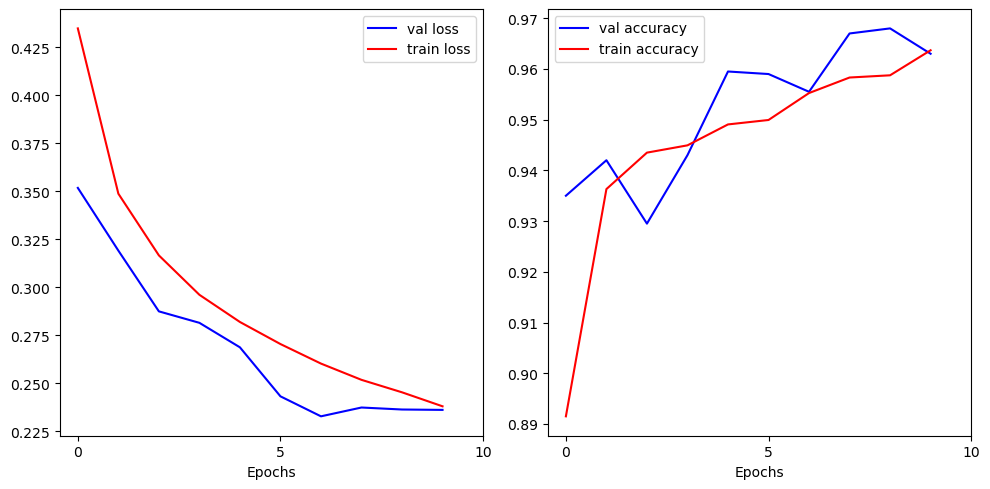

In [5]:

###################
# Hyperparameters #

n_samples = 10000
n_samples_train = int(round(n_samples*0.8))
n_samples_val = int(round(n_samples*0.2))
batch_size = 20
current_computer =  "ubuntu" # "macbook" 
layers_to_freeze = 0
lr = 0.00001
weight_decay=0.04
num_epochs = 10
im_size = 200
min_palsa_positive_samples = 10


##########################
# log hyperparams to w&b #

run = wandb.init(
    # Set the project where this run will be logged
    project="VGG_CAMs",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "n_samples": n_samples,
        "layers_to_freeze": layers_to_freeze,
        "weight_decay": weight_decay,
        "im_size": im_size,
        "min_palsa_positive_samples": min_palsa_positive_samples
    },
    tags=['4D', 'LRScheduler', 'MSELoss', 'TrainFromScratch', 'NormedImgs']
)

#############
# Load data #

if current_computer == "ubuntu":
    hs_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/hs'
    RGB_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/rgb'
    labels_file = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

# Load the labels from the CSV file
if min_palsa_positive_samples > 0:
    labels_df = pd.read_csv(labels_file, index_col=0)
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] < min_palsa_positive_samples) ].index

    labels_df.drop(drop_range, inplace=True)
    labels_df = labels_df.head(n_samples)
else: 
    labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)


# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df, im_size)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df, im_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
trans_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.CrossEntropyLoss()

##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)  
        labels = Variable(labels.long()).to(device)  

        # train batch   
        outputs = model(images) 
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs, labels.long()))
        running_loss += loss.item()
        train_batch_count += 1


    """
    NOTE:
    The way in which training of transformed data is implemented here is probably 
    undesirable because it first trains a whole epoch on normal images and then 
    transformed. Ideally would probably be shuffled.
    """
    
    # Train on transformed data 
    for batch_idx, (images, labels) in enumerate(trans_loader):     

        # load images and labels 
        images = Variable(images).to(device)  
        labels = Variable(labels.long()).to(device)  

        # train batch   
        outputs = model(images) 
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs, labels.long()))
        running_loss += loss.item()
        train_batch_count += 1

    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):     
            # load images and labels 
            images = Variable(images).to(device)  
            labels = Variable(labels.long()).to(device)  
            outputs = model(images) 
            loss = loss_function(outputs, labels)

            val_acc.append(accuracy(outputs, labels))
            val_running_loss += loss.item()
            val_batch_count +=1

    scheduler.step()

    # update losses and accuracies 

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    wandb.log({"train_accuracy": np.mean(train_acc)})
    wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

    if np.mean(val_acc) > max_val_acc:
        best_model = model.state_dict()
        max_val_acc = np.mean(val_acc)


torch.save(best_model, '/home/nadjaflechner/models/model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('/home/nadjaflechner/models/model.pth')
run.log_artifact(artifact)

##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()

wandb.log({'model_performance': wandb.Image(fig)})

####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
palsa_imgs = 0
for palsa_cam in range(100):
    im, lab = next(iter(valid_loader))

    #get the last convolution
    sf = SaveFeatures(model.features[-4])
    model.eval()

    if lab.sum().detach().cpu().numpy() == 2: # if both classes present in image
        palsa_imgs+= 1
        im = Variable(im).to(device)
        outputs = model(im).to(device)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach().numpy()
        arr1 = arr[0]
        ans_nopalsa = np.dot(np.rollaxis(arr1,0,3), [1,0])
        ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0,1])

        CAM_pals = resize(ans_palsa, (im_size*2,im_size*2))
        CAM_nopals = resize(ans_nopalsa, (im_size*2,im_size*2))

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,6))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title(f'original image')

        ax2.imshow(cpu_img)
        ax2.imshow(CAM_pals, alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('Palsa feature map')

        ax3.imshow(cpu_img)
        ax3.imshow(CAM_nopals, alpha=.4, cmap='jet')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('No_Palsa feature map')

        plt.tight_layout()

        wandb.log({'generated_CAM': fig})

    if palsa_imgs == 20:
        break


wandb.finish()
